In [2]:
import numpy as np
from math import *
import matplotlib.cm as cm
from scipy.signal import convolve, deconvolve
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from PIL import Image, ImageDraw
from PIL import ImageFilter
from PIL import ImageColor
from pathlib import Path
import random
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
import glob
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

# Functions

## Creation of the signal

In [3]:
def generate_signal(FR, tau_decay, Fs, noise_sigma, duration): #code de 1D du prof modulo rajout de l'amplitude
    dt = 1 / Fs
    N = int(duration / dt)
    spikes = np.random.rand(N) < FR * dt
    num_spikes = np.sum(spikes)
    amplitudes = 1 # np.random.normal(loc=1, scale=0.5, size=(num_spikes,))
    #amplitudes[amplitudes<0.2] = 0.2
    spike_train = np.zeros(spikes.shape)
    spike_train[spikes==True] = amplitudes  
    t = np.arange(-duration//2, duration//2, dt)
    exponential = np.zeros_like(t)
    exponential[t>=0] = np.exp(-t[t>=0]/tau_decay)
    
    #q = np.zeros(spikes.shape)
    #j = 0
    #for i in range(np.size(spikes,axis=0)):
     #   if spikes[i] == True:
      #      q[i]= amplitudes[j]

    
    signal = convolve(spikes, exponential, mode='same')
    
    # !!!!!!!!!!!!!!!!
    signal = signal/np.max(signal)
    
    time = np.arange(0, duration, dt)
    return signal, spikes, time, num_spikes

In [4]:
FR = 0.5 # average firing rate over time
tau_decay = 0.25 # true decay rate of exponentials
Fs = 5 # sampling rate
noise_sigma = 0.15 # STD of gaussian noise
duration = 60 # full signal duration in seconds

In [5]:
signal_1, spikes_1, time_1, num_spikes_1 = generate_signal(FR, tau_decay, Fs, noise_sigma, duration)
print('1: True number of spikes = {}'.format(num_spikes_1))
print('1: Assumed number of spikes input to the method = {}'.format(int(FR*duration)))

signal_2, spikes_2, time_2, num_spikes_2 = generate_signal(FR, tau_decay, Fs, noise_sigma, duration)
print('2: True number of spikes = {}'.format(num_spikes_2))
print('2: Assumed number of spikes input to the method = {}'.format(int(FR*duration)))

signal_3, spikes_3, time_3, num_spikes_3 = generate_signal(FR, tau_decay, Fs, noise_sigma, duration)
print('3: True number of spikes = {}'.format(num_spikes_3))
print('3: Assumed number of spikes input to the method = {}'.format(int(FR*duration)))

1: True number of spikes = 35
1: Assumed number of spikes input to the method = 30
2: True number of spikes = 26
2: Assumed number of spikes input to the method = 30
3: True number of spikes = 24
3: Assumed number of spikes input to the method = 30


Text(0.5, 1.0, 'True Spike Locations')

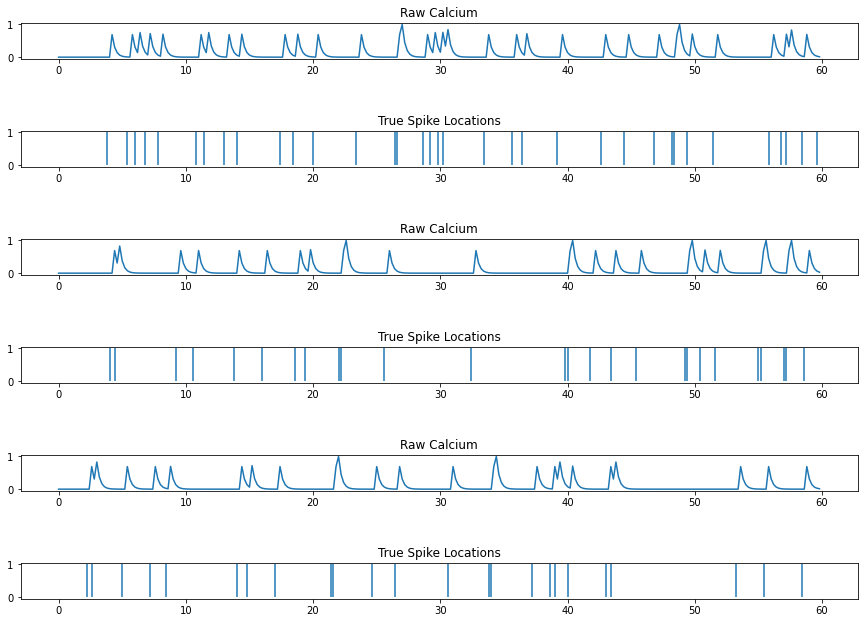

In [6]:
fig, ax = plt.subplots(6,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 2) 

ax[0].plot(time_1, signal_1)
ax[0].set_title('Raw Calcium')
ax[1].stem(time_1, spikes_1, use_line_collection=True, markerfmt=" ", basefmt=" ")
ax[1].set_title('True Spike Locations')

ax[2].plot(time_2, signal_2)
ax[2].set_title('Raw Calcium')
ax[3].stem(time_2, spikes_2, use_line_collection=True, markerfmt=" ", basefmt=" ")
ax[3].set_title('True Spike Locations')

ax[4].plot(time_3, signal_3)
ax[4].set_title('Raw Calcium')
ax[5].stem(time_3, spikes_3, use_line_collection=True, markerfmt=" ", basefmt=" ")
ax[5].set_title('True Spike Locations')

## Creation of the picture

In [7]:
def position_cells(pix_1,pix_2, horiz_1, vert_1, horiz_2, vert_2, horiz_3, vert_3):
    # ellipse 1
    x_1_1 = pix_1//2 
    y_1_1 = pix_2//3 
    
    x_1_2 = x_1_1 + horiz_1
    y_1_2 = y_1_1 + vert_1
    
    # ellipse 2
    x_2_1 = random.randint(x_1_1-horiz_1+5, x_1_1+horiz_1-5)
    while abs(x_1_1-x_2_1)<3:
         x_2_1 = random.randint(x_1_1-horiz_1+5, x_1_1+horiz_1-5) 
    y_2_1 = y_1_1
    
    x_2_2 = x_2_1 + horiz_2
    y_2_2 = y_2_1 + vert_2
    
    # ellipse 3
    x_3_1 = random.randint(0,pix_1-horiz_3)
    y_3_1 = random.randint(0,pix_2-vert_3)
    
    while  ((y_3_1 >(y_1_1-vert_3-5) and y_3_1 < (y_1_2 + 5)) and (x_3_1> (x_1_1-horiz_3-5) and x_3_1<(x_1_2+5))) or ((y_3_1 >(y_2_1-vert_3-5) and y_3_1 < (y_2_2 + 5)) and (x_3_1> (x_2_1-horiz_3-5) and x_3_1<(x_2_2+5))):
        x_3_1 = random.randint(0,pix_1-horiz_3)
        y_3_1 = random.randint(0,pix_2-vert_3)
    
    x_3_2 = x_3_1 + horiz_3
    y_3_2 = y_3_1 + vert_3

    return x_1_1,y_1_1,x_1_2,y_1_2, x_2_1,y_2_1,x_2_2,y_2_2, x_3_1,y_3_1,x_3_2,y_3_2

In [8]:
def generate_image(pix_1, pix_2, x_1_1,y_1_1,x_1_2,y_1_2):
    
    # creating new Image object
    w, h = pix_1, pix_2
    img = Image.new("L", (w, h), "Black")
    
    # create image
    img1 = ImageDraw.Draw(img)

    img1.ellipse([(x_1_1,y_1_1),(x_1_2,y_1_2)], fill = 255 , outline = 255)
    
    img.show()
    return img

In [9]:
pix_1 = 50
pix_2 = 50

horiz_1 = 10
vert_1 = 10

horiz_1 = 8
vert_1 = 10

horiz_2 = 6
vert_2 = 15

horiz_3 = 15
vert_3 = 5

x_1_1,y_1_1,x_1_2,y_1_2, x_2_1,y_2_1,x_2_2,y_2_2, x_3_1,y_3_1,x_3_2,y_3_2 = position_cells(pix_1,pix_2, horiz_1, vert_1, horiz_2,vert_2 , horiz_3, vert_3)

im_1 = generate_image(pix_1, pix_2, x_1_1,y_1_1,x_1_2,y_1_2)
im_2 = generate_image(pix_1, pix_2, x_2_1,y_2_1,x_2_2,y_2_2)
im_3 = generate_image(pix_1, pix_2, x_3_1,y_3_1,x_3_2,y_3_2)

img = Image.new("L", (pix_1, pix_2), "Black")

img.paste(im_1, None, im_1)
img.paste(im_2, None, im_2)
img.paste(im_3, None, im_3)

img.show()

# Add the components together

## Without noise

In [10]:
image_1 = np.array(im_1)
image_1 = np.concatenate(image_1)
image_1 = np.array([image_1]).T

image_2 = np.array(im_2)
image_2 = np.concatenate(image_2)
image_2 = np.array([image_2]).T

image_3 = np.array(im_3)
image_3 = np.concatenate(image_3)
image_3 = np.array([image_3]).T

D_true = np.hstack([image_1,image_2,image_3])
print(D_true.shape)

A_true = np.vstack([signal_1, signal_2,signal_3])
print(A_true.shape)

X_true = np.dot(D_true, A_true)
X_true = X_true/np.max(X_true)*255
print(X_true.shape)
print(np.min(X_true), np.max(X_true))

(2500, 3)
(3, 300)
(2500, 300)
0.0 255.0


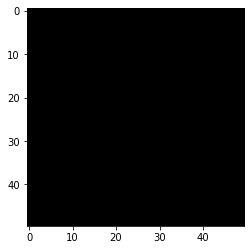

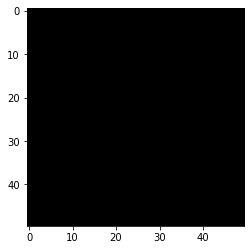

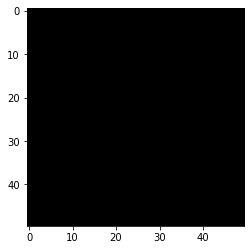

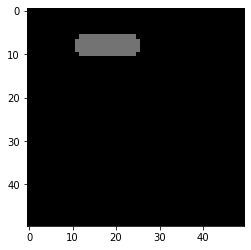

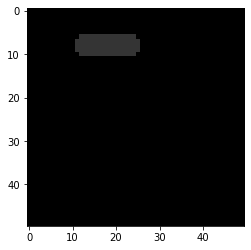

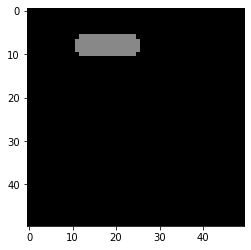

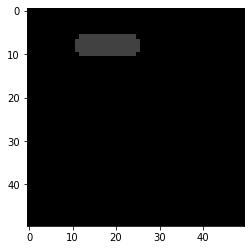

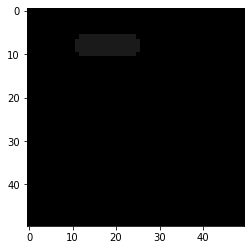

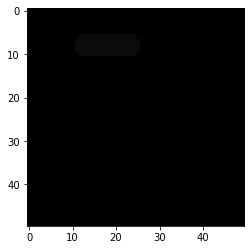

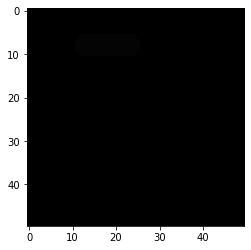

In [14]:
for i in range(10):
    plt.imshow(X_true[:,i+10].reshape((50,50)), cmap='Greys_r', vmin= np.min(X_true), vmax = np.max(X_true))
    
    plt.show()
    

## With noise

0.0 255.0


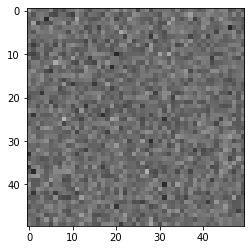

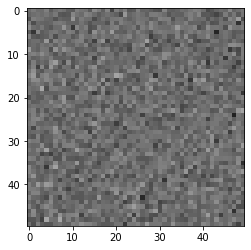

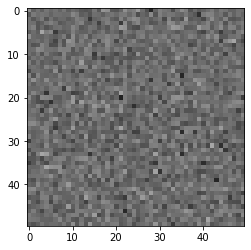

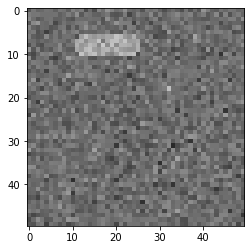

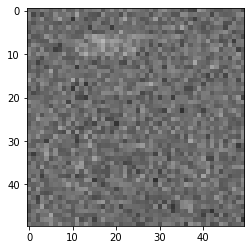

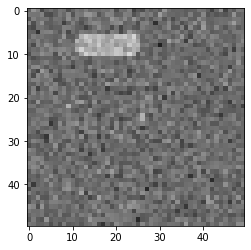

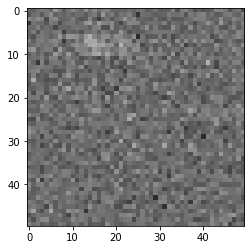

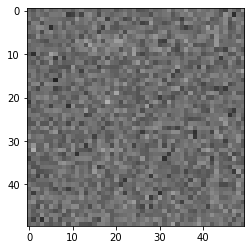

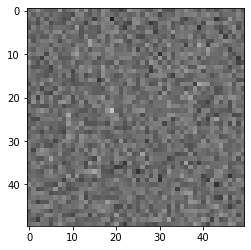

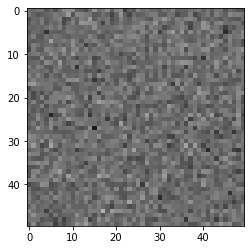

In [22]:
noise = (e**(-3*log(2)))*np.random.normal(size = (2500,300))
X_true_noise = (X_true/np.max(X_true) + noise)
if np.min(X_true_noise) <0:
    X_true_noise = X_true_noise - np.min(X_true_noise) 
X_true_noise = X_true_noise/np.max(X_true_noise)*255

print(np.min(X_true_noise), np.max(X_true_noise))

for i in range(10):
    plt.imshow(X_true_noise[:,i+10].reshape((50,50)), cmap='Greys_r', vmin= np.min(X_true_noise), vmax = np.max(X_true_noise))
    
    plt.show()

# Make the videos

## Without noise

In [16]:
import os
 
size = 50, 50
hieght = 50
channel = 3
 
fps = 5
sec = 60
 
# Syntax: VideoWriter_fourcc(c1, c2, c3, c4) # Concatenates 4 chars to a fourcc code
#  cv2.VideoWriter_fourcc('M','J','P','G') or cv2.VideoWriter_fourcc(*'MJPG)
 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # FourCC is a 4-byte code used to specify the video codec.
# A video codec is software or hardware that compresses and decompresses digital video. 
# In the context of video compression, codec is a portmanteau of encoder and decoder, 
# while a device that only compresses is typically called an encoder, and one that only 
# decompresses is a decoder. Source - Wikipedia
 
#Syntax: cv2.VideoWriter( filename, fourcc, fps, frameSize )
#video = cv2.VideoWriter('test.mp4', fourcc, float(fps), (width, hieght))
video = cv2.VideoWriter('activity_cells.mp4', cv2.VideoWriter_fourcc(*'DIVX'), fps, (size[1], size[0]), False)
 
for frame_count in range(fps*sec):
    img =  (X_true[:,frame_count].reshape((50,50))).astype(np.uint8)
    video.write(img)
 
video.release()

## With noise

In [17]:

width = 50
hieght = 50
channel = 3
 
fps = 5
sec = 60
 
# Syntax: VideoWriter_fourcc(c1, c2, c3, c4) # Concatenates 4 chars to a fourcc code
#  cv2.VideoWriter_fourcc('M','J','P','G') or cv2.VideoWriter_fourcc(*'MJPG)
 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # FourCC is a 4-byte code used to specify the video codec.
# A video codec is software or hardware that compresses and decompresses digital video. 
# In the context of video compression, codec is a portmanteau of encoder and decoder, 
# while a device that only compresses is typically called an encoder, and one that only 
# decompresses is a decoder. Source - Wikipedia
 
#Syntax: cv2.VideoWriter( filename, fourcc, fps, frameSize )
#video = cv2.VideoWriter('test.mp4', fourcc, float(fps), (width, hieght))
video = cv2.VideoWriter('activity_cells_noise.mp4', cv2.VideoWriter_fourcc(*'DIVX'), fps, (size[1], size[0]), False)
 
for frame_count in range(fps*sec):
    img =  (X_true_noise[:,frame_count].reshape((50,50))).astype(np.uint8)
    video.write(img)
 
video.release()

In [38]:
np.savetxt('X_true.txt', X_true)
np.savetxt('D_true.txt', D_true)
np.savetxt('A_true.txt', A_true)
np.savetxt('X_true_noise.txt', X_true_noise)
np.savetxt('noise.txt', noise)

## Smooth data

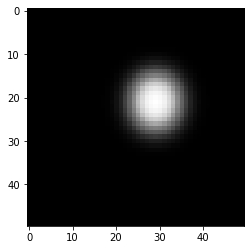

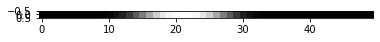

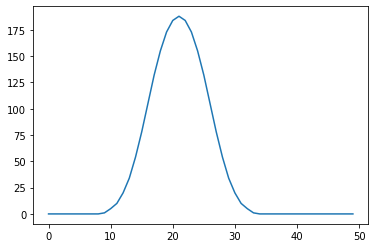

In [26]:
a = D_true[:,0].reshape((50,50))
b = gaussian_filter(a, sigma=3, truncate=4)

plt.imshow(b.reshape((50,50)), cmap='Greys_r')
plt.show()
plt.imshow(b[:,30].reshape((1,50)), cmap='Greys_r')
plt.show()
plt.plot(np.arange(0,50,1), b[:,30]) #values of y when x = 30
plt.show()

In [28]:
a_0 = D_true[:,0].reshape((50,50))
b_0 = gaussian_filter(a_0, sigma=3, truncate=4)
b_0 = np.concatenate(b_0)
b_0 = b_0/np.max(b_0)*255

a_1 = D_true[:,1].reshape((50,50))
b_1 = gaussian_filter(a_1, sigma=3, truncate=4)
b_1 = np.concatenate(b_1)
b_1 = b_1/np.max(b_1)*255

a_2 = D_true[:,2].reshape((50,50))
b_2 = gaussian_filter(a_2, sigma=3, truncate=4)
b_2 = np.concatenate(b_2)
b_2 = b_2/np.max(b_2)*255

D_smooth = np.array([b_0,b_1,b_2]).T
print(D_smooth.shape)
print(np.max(D_smooth))

(2500, 3)
255.0


In [30]:
np.savetxt('D_true_smooth.txt', D_smooth) 